# Final Resource

## Introduction

As the sports industry continues to grow over time, the integration of advanced analytics via statistics and machine learning plays a vital role in how professional sporting teams operate and play. Is it possible to predict outcomes of sporting events given historical data, and if so, how accurately?

This report will answer the research question: *can historical data on NCAA basketball results be used to predict outcomes of future matches?* We will be using the dataset from the [Google Cloud & NCAA® ML Competition 2018-Men'](https://www.kaggle.com/c/mens-machine-learning-competition-2018) competition to build and test machine learning models. To predict the outcome of a given basketball game, our team is interested in comparing a team's recent performance (based on the last 8 games of the season) and current Elo score (a team's "rating"), against other team's recent performance and Elo score.

Our hypothesis is: *Does utilizing ELO ranking given historical accompanied by a team’s recent performance allow for us to predict if team A will beat team B in a game of basketball?* Specifically, our end result will be the probability that team A beats team B for each matchup in the 2017 March Madness tournament. We will test this by measuring the accuracy of our model to predict the outcomes of the 2017 March Madness tournament since the seeds for 2018 have not been released. We will then use the accuracy of our results in our final evaluation.


## Dataset Overview
This dataset includes historical data from both the regular season and NCAA championship tournaments. We will only use up to 2017 regular season data, but not train the model with 2017 tournament data, as this would skew our results. Our exploratory data analysis will include the whole data set to show the breadth of the data. 


## Statistical and Machine Learning Methods 
For stat-analysis, we utilized statistical analysis to perform EDA, and utilize logistic regression models to predict trends/analyze our research question. We will also utilize ELO-Ranking as our metric for determining probabilities of winning basketball games, which will be aggregated over seasons from 1985 - 2017.

For machine learning, we plan to use either logistic regression, xgboost, or another boosting algorithm for machine learning, paired with proper cross-validation / GridSearchCV.

## Set-up

In [1]:
# Set up
import mm_predictor as predictor
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
matplotlib.style.use('ggplot')
%matplotlib inline
import random
from scipy import stats


# Load the data
cities = pd.read_csv('./ncaa-data/Cities.csv')
conf = pd.read_csv('./ncaa-data/Conferences.csv')
confGames = pd.read_csv('./ncaa-data/ConferenceTourneyGames.csv')
gameCities = pd.read_csv('./ncaa-data/GameCities.csv')
tCompRes = pd.read_csv('./ncaa-data/NCAATourneyCompactResults.csv')
tDetRes= pd.read_csv('./ncaa-data/NCAATourneyDetailedResults.csv')
tSeedRoundSlots = pd.read_csv('./ncaa-data/NCAATourneySeedRoundSlots.csv')
tSeeds = pd.read_csv('./ncaa-data/NCAATourneySeeds.csv')
tSlots = pd.read_csv('./ncaa-data/NCAATourneySlots.csv')
regCompRes = pd.read_csv('./ncaa-data/RegularSeasonCompactResults.csv')
regDetRes = pd.read_csv('./ncaa-data/RegularSeasonDetailedResults.csv')
seasons = pd.read_csv('./ncaa-data/Seasons.csv')
secTCompRes = pd.read_csv('./ncaa-data/SecondaryTourneyCompactResults.csv')
secTTeams = pd.read_csv('./ncaa-data/SecondaryTourneyTeams.csv')
teamCoaches = pd.read_csv('./ncaa-data/TeamCoaches.csv')
teamConf = pd.read_csv('./ncaa-data/TeamConferences.csv')
teams = pd.read_csv('./ncaa-data/Teams.csv')

C:\Users\pearl\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Overview
To get started, here is a brief data overview of the teams, seasons, seeds, regular season compact results, and tourney and regular season detailed results. This will help you get familiarize with the dataset. 

### Teams
There are 351 college teams currently in Division-I, and an overall total of 364 teams in the dataset. Each team has a 4 digit id number.

> **TeamID** - a 4 digit id number, from 1000-1999, uniquely identifying each NCAA® men's team.

> **TeamName** - a compact spelling of the team's college name, 16 characters or fewer. There are no commas or double-quotes in the team names, but you will see some characters that are not letters or spaces (e.g., Texas A&M, St Mary's CA, etc.)

> **FirstD1Season** - the first season in our dataset that the school was a Division-I school. Many schools were Division-I far earlier than 1985, but since we don not have any data included prior to 1985, all such teams are listed with a FirstD1Season of 1985.

> **LastD1Season** - the last season in our dataset that the school was a Division-I school. For any teams that are currently Division-I, they will be listed with LastD1Season=2018, and you can confirm there are 351 such teams. 


In [2]:
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


### Seasons
This dataset identifies the different seasons included in the historical data, along with certain season-level properties.
> **Season** - indicates the year in which the tournament was played

> **DayZero** - tells you the date corresponding to daynum=0 during that season. All game dates have been aligned upon a common scale so that the championship game of the final tournament is on daynum=154. Working backward, the national semifinals are always on daynum=152, the "play-in" games are on days 134/135, Selection Sunday is on day 132, and so on. All game data includes the day number in order to make it easier to perform date calculations. If you really want to know the exact date a game was played on, you can combine the game's "daynum" with the season's "dayzero".

> **RegionW, RegionX, Region Y, Region Z** - by convention, the four regions in the final tournament are always named W, X, Y, and Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files. So for that season, the W/X/Y/Z are East,Midwest,South,West.

In [3]:
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


### NCAA Tourney Seed
This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with eight "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week. We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 11, 2018.

> **Season** - the year that the tournament was played in

>  **Seed** - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tells you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have seeds with the same first three characters. For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "Seasons.csv" file was the East region).

>  **TeamID** - this identifies the id number of the team, as specified in the Teams.csv file

In [14]:
tSeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Regular Season Compact Results
This datset identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from daynum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, etc.

> **Season** - this is the year of the associated entry in Seasons.csv (the year in which the final tournament occurs)

> **DayNum** - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "Seasons.csv" file.

> **WTeamID** - this identifies the id number of the team that won the game, as listed in the "Teams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.

> **WScore** - this identifies the number of points scored by the winning team.

> **LTeamID** - this identifies the id number of the team that lost the game.

> **LScore** - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.

> **NumOT** - this indicates the number of overtime periods in the game, an integer 0 or higher.

> **WLoc** - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N".

In [5]:
regCompRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


### NCAA Tourney Detailed Results
This file provides team-level box scores for many NCAA® tournaments, starting with the 2003 season. All games listed in the NCAATourneyCompactResults file since the 2003 season should exactly be present in the NCAATourneyDetailedResults file. The **W** represents for winning team, and the **L** represents the losing team. 
> **FGM** — Field Goals Made

> **FGA** — Field Goals Attempted

> **FGM3** — Three Pointers Made

> **FGA3** — Three Pointers Attempted

> **FTM** — Free Throws Made

> **FTA** — Free Throws Attempted

> **OR** — Offensive Rebounds

> **DR** — Defensive Rebounds

> **AST** — Assists

> **TO** — Turnovers

> **STL** — Steals

> **BLK** — Bocks

> **PF** — Personal Fouls

In [22]:
tDetRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


### Regular Season Detailed Results
This file provides team-level box scores for many regular seasons of historical data, starting with the 2003 season. All games listed in the RegularSeasonCompactResults file since the 2003 season should exactly be present in the RegularSeasonDetailedResults file.
> **FGM** — Field Goals Made

> **FGA** — Field Goals Attempted

> **FGM3** — Three Pointers Made

> **FGA3** — Three Pointers Attempted

> **FTM** — Free Throws Made

> **FTA** — Free Throws Attempted

> **OR** — Offensive Rebounds

> **DR** — Defensive Rebounds

> **AST** — Assists

> **TO** — Turnovers

> **STL** — Steals

> **BLK** — Bocks

> **PF** — Personal Fouls

In [23]:
regDetRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


## Exploratory Data Analysis

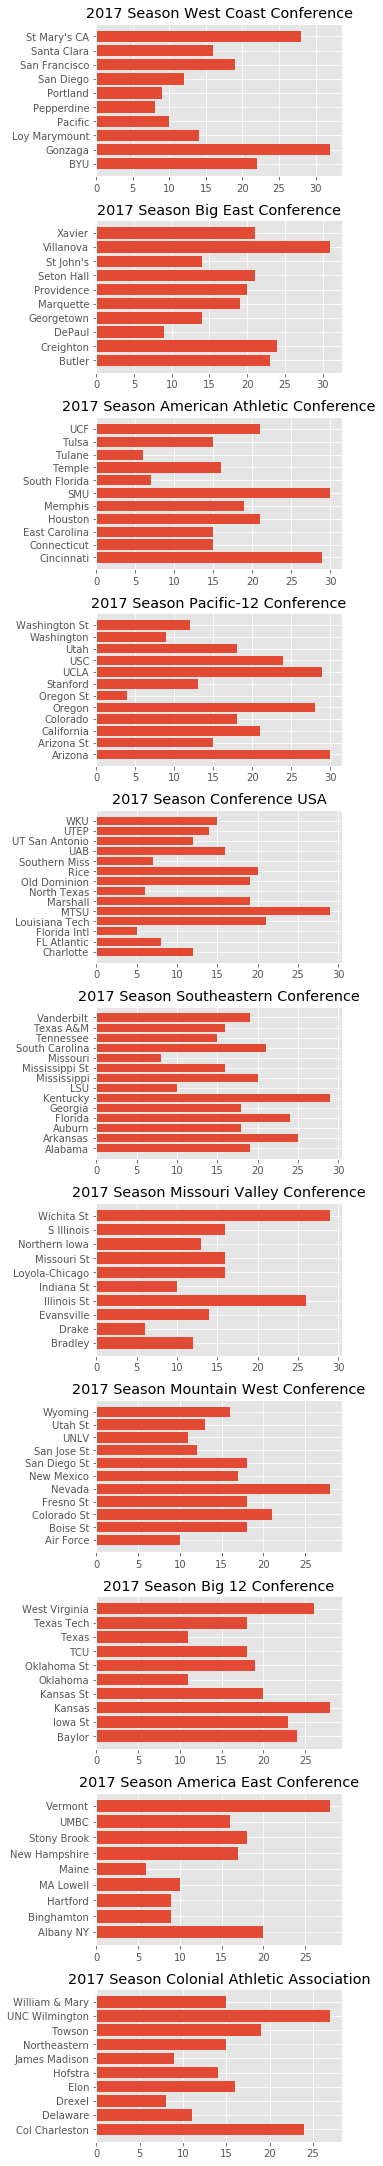

In [5]:
# Total number of wins per team for each conference in 2017

# Merging columns
winsDF = regCompRes.loc[regCompRes['Season'] == 2017].groupby('WTeamID').size().to_frame().reset_index()
winsDF.columns = ["TeamID", "Wins"] # rename columns
wins_df = pd.merge(winsDF,teams,on='TeamID')
wins_df = pd.merge(wins_df, teamConf, on='TeamID')
wins_df = pd.merge(wins_df, conf, on = 'ConfAbbrev')

# Deleting unecessary columns
del wins_df['TeamID'] 
del wins_df['FirstD1Season'] 
del wins_df['LastD1Season']
del wins_df['ConfAbbrev']

# Selecting the year
wins_df = wins_df.loc[wins_df['Season'] == 2017]
wins_df= wins_df.sort_values(by=['Wins'], ascending = False)

# Renaming columns
wins_df.rename(columns={'Description':'Conference Name'}, inplace=True)

# Graphing the results
conferences = wins_df['Conference Name'].unique()
fig, axes = plt.subplots(ncols=1, nrows=11, figsize=(5,30))
for i, ax in enumerate(axes.flat):
    conf_data = wins_df.loc[wins_df['Conference Name'] == conferences[i]].dropna()
    ax.barh(conf_data['TeamName'], conf_data['Wins'])
    ax.set_title("2017 Season " + conferences[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# nplt.show()

> Here, the graphs above reveal the total number of wins per team for each conference in 2017 (ex. for the West Coast Conference, Gonzaga had the most amount of wins, whereas Pepperdine had the least). This gives us a good overview of the teams that had the most amount of wins compared to the other teams in the same each area. Then we can use this to compare their wins against the other conferences. 

<function matplotlib.pyplot.show>

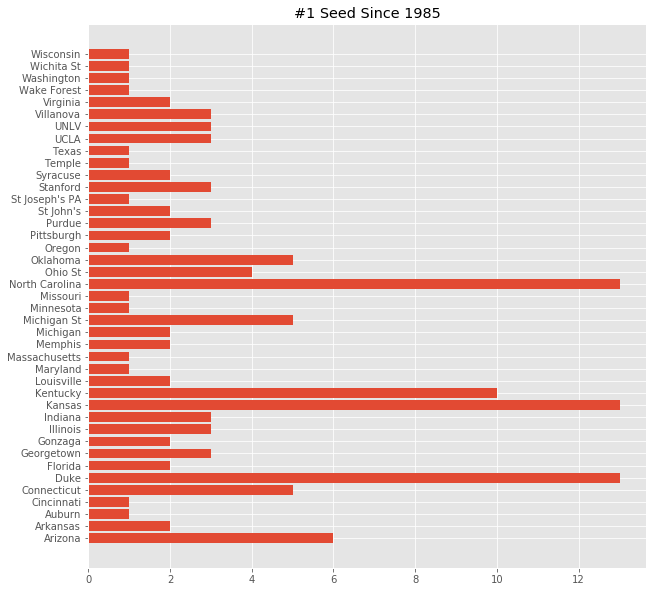

In [6]:
# Number of times a team has gotten the numbeer 1 seed since 1985

# Copy the original data
seed_count = tSeeds.copy(deep=True)

# Remove the region from the seed
seed_only = seed_count['Seed'].str[1:]

# Replace the old seed col with the new one without region 
seed_count['Seed'] = seed_only

# Replace all the 01 objects with an int of 1
seed_count['Seed'].replace({'01': 1}, inplace=True)

# Filter the dataframe to only show teams with #1 seed
seed_count = seed_count.loc[seed_count['Seed'] == 1]

# Count how many times a team has been #1 seed
seed_count = seed_count.groupby('TeamID').size().to_frame().reset_index()

# Replace TeamID with TeamName
seed_count = pd.merge(seed_count,teams,on='TeamID')

# Delete uneeded columns
del seed_count['FirstD1Season'] 
del seed_count['LastD1Season']
del seed_count['TeamID']

# Rename columns
seed_count.rename(columns={0:'#1 Seed Count'}, inplace=True)

# Sort by descending order
seed_count = seed_count.sort_values('#1 Seed Count', ascending=False)

seed_count
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.barh(seed_count['TeamName'], seed_count['#1 Seed Count'])
ax.set_title("#1 Seed Since 1985")
plt.show

> The graph above shows the number of times each team has been the number 1 seed since 1985. Out of all the colleges, North Carolina, Kansas, and Duke have gotten the number 1 seed the most amount of times compared to the other teams. From here we can see that these three teams have consistently (and drastically) been the number 1 seed in comparison to other college teams.   

<function matplotlib.pyplot.show>

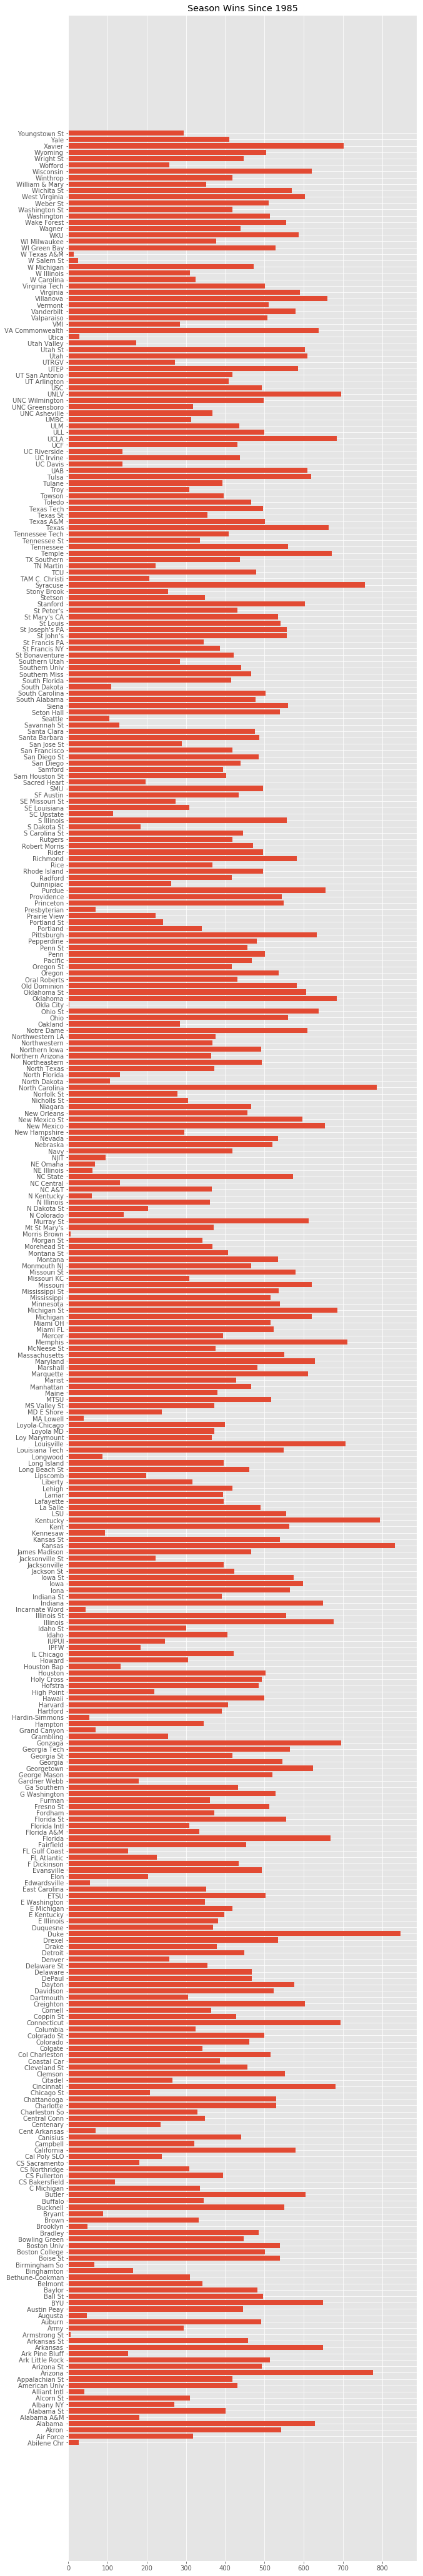

In [7]:
# Season wins, per team, since 1985
# Group by winning team ID to see how many times a team has won since 1985
num_wins = regCompRes.groupby('WTeamID').size().to_frame().reset_index()

# Rename WTeamID column to prep merge
num_wins.rename(columns={"WTeamID":'TeamID'}, inplace=True)

# Merge to convert TeamID to TeamName
num_wins = pd.merge(num_wins,teams,on='TeamID')

# Delete uneeded columns
del num_wins['FirstD1Season'] 
del num_wins['LastD1Season']
del num_wins['TeamID']

# Rename col to better represent number of wins
num_wins.rename(columns={0:'Wins'}, inplace=True)

# Sort by descending order
num_wins = num_wins.sort_values('Wins', ascending=False)

fig = plt.figure(figsize=(10,75))
ax = fig.add_subplot(111)
ax.barh(num_wins['TeamName'], num_wins['Wins'])
ax.set_title("Season Wins Since 1985")
plt.show

> This graph provides an overview of the season wins for each team since 1985. Similar to the previous graph, the North Carolina, Kansas, and Duke teams have been performing well since 1985, with the most amount of season wins along with Kentucky and Arizona. 

## Data Analysis 



In [8]:
## Find out which teams played in the 2017 season 

# Copy original data
teams_2017 = tDetRes.copy(deep=True)

# Only look at 2017 season
teams_2017 = teams_2017[teams_2017.Season == 2017]

# Teams who won in 2017
winning_set = set(teams_2017['WTeamID'].unique())

# Teams who lost in 2017
losing_set = set(teams_2017['LTeamID'].unique())

# Combine both set, remove duplicates, convert into list 
teams_2017 = list(winning_set.union(losing_set))

# All the teams who played in 2017 season
teams_2017

## Get all of the team's ELO who played in 2017

team_2017_elos = {}

# Init stat & elo dictionaries 
predictor.init()

# Load data
tourney_data = tDetRes.copy(deep=True)
tourney_data = tourney_data[tourney_data.Season != 2017]

aggregated_data = pd.concat([regDetRes, tourney_data])

X,Y = predictor.analyze_teams(aggregated_data)

# Finds the elo for all the teams who played in 2017, saves into a dict
for team in teams_2017:
    current_elo = predictor.get_elo(2017, team)
    team_elo = {team: current_elo}
    team_2017_elos.update(team_elo)
    
team_2017_elos

{1112: 2161,
 1116: 1980,
 1124: 2069,
 1137: 1684,
 1139: 2046,
 1153: 2042,
 1166: 1995,
 1173: 1956,
 1181: 2134,
 1190: 1719,
 1195: 1672,
 1196: 2017,
 1199: 2024,
 1211: 2134,
 1233: 1698,
 1235: 2084,
 1240: 1489,
 1242: 2199,
 1243: 1926,
 1245: 1721,
 1246: 2156,
 1257: 2095,
 1266: 1945,
 1268: 2015,
 1274: 2036,
 1276: 2040,
 1277: 1998,
 1278: 1931,
 1291: 1499,
 1292: 1897,
 1297: 1643,
 1300: 1477,
 1305: 1914,
 1308: 1775,
 1309: 1472,
 1314: 2142,
 1315: 1583,
 1321: 1936,
 1323: 2085,
 1329: 1947,
 1332: 2140,
 1343: 1822,
 1344: 1993,
 1345: 2086,
 1348: 1926,
 1355: 1686,
 1371: 2036,
 1374: 2109,
 1376: 1920,
 1388: 2010,
 1407: 1562,
 1411: 1532,
 1413: 1619,
 1417: 2078,
 1423: 1838,
 1425: 1938,
 1433: 1963,
 1435: 1943,
 1436: 1785,
 1437: 2216,
 1438: 2082,
 1439: 1966,
 1448: 1882,
 1452: 2094,
 1455: 2056,
 1457: 1658,
 1458: 2043,
 1462: 1990}

In [9]:
# Convert 2017 dictionary into a list 
teams_2017_list = list(team_2017_elos.items())
df_2017 = pd.DataFrame(data=teams_2017_list)

# Rename first col to 'TeamID' to prep merge, rename second col to represent ELO
df_2017.rename(columns={0:'TeamID', 1: 'ELO'}, inplace=True)

# Merge to convert TeamID to TeamName
df_2017 = pd.merge(df_2017,teams,on='TeamID')

# Delete unneeded columns
del df_2017['FirstD1Season']
del df_2017['LastD1Season']

df_2017

,TeamID,ELO,TeamName
0,1291,1499,Mt St Mary's
1,1292,1897,MTSU
2,1297,1643,N Kentucky
3,1300,1477,NC Central
4,1305,1914,Nevada
5,1308,1775,New Mexico St
6,1309,1472,New Orleans
7,1314,2142,North Carolina
8,1315,1583,North Dakota
9,1321,1936,Northwestern


<function matplotlib.pyplot.show>

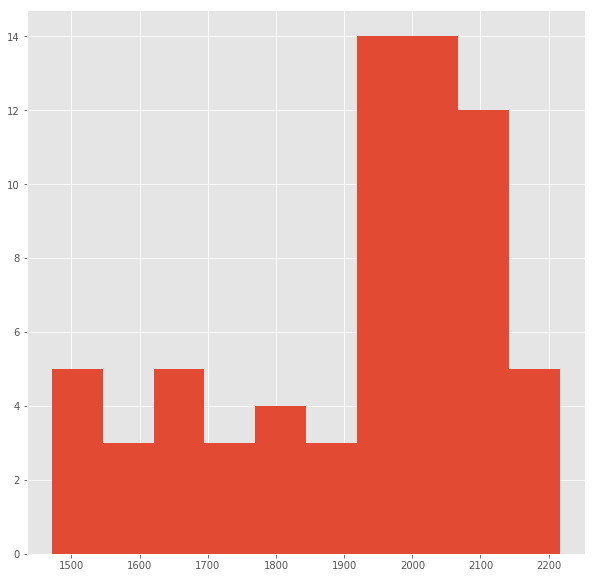

In [10]:
# Histogram of the ELO scores
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.hist(df_2017['ELO'], bins=10)
plt.show

> From the histogram above, we can see that the graph is relatively normally distributed. Thus, about 95% of the observations (ELO scores) will fall within 2 standard deviations of the mean.

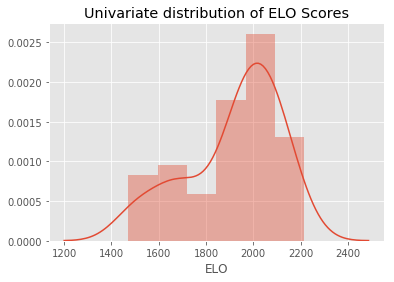

In [21]:
# Univariate distribution of the ELO scores
plt.title('Univariate distribution of ELO Scores')

sns.distplot(df_2017['ELO']);

> From the univariate distribution above, we get a sense for how the ELO scores are distributed. From the curve, we can see that the distribution appears bimodal (two modes). The main peak is in between an ELO score of 2000 and 2200, whereas the second and lower peak is at 1600. 

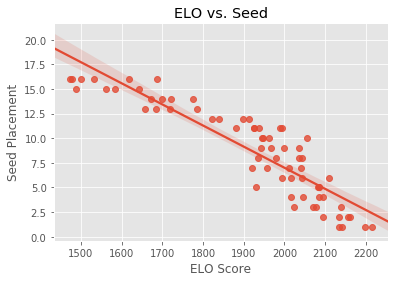

In [12]:
# Compare the relationship between the ELO scores and the seed placement
# Copy the original data
seed_2017 = tSeeds.copy(deep=True)

# Remove all non 2017 season data
seed_2017 = seed_2017.loc[seed_2017['Season'] == 2017]

# Remove the region from the seed
seed_only = seed_2017['Seed'].str[1:]

# Replace the old seed col with the new one without region 
seed_2017['Seed'] = seed_only

# Replace all the seed objects with an int
seed_2017['Seed'].replace({'01': 1}, inplace=True)
seed_2017['Seed'].replace({'02': 2}, inplace=True)
seed_2017['Seed'].replace({'03': 3}, inplace=True)
seed_2017['Seed'].replace({'04': 4}, inplace=True)
seed_2017['Seed'].replace({'05': 5}, inplace=True)
seed_2017['Seed'].replace({'06': 6}, inplace=True)
seed_2017['Seed'].replace({'07': 7}, inplace=True)
seed_2017['Seed'].replace({'08': 8}, inplace=True)
seed_2017['Seed'].replace({'09': 9}, inplace=True)
seed_2017['Seed'].replace({'10': 10}, inplace=True)
seed_2017['Seed'].replace({'11': 11}, inplace=True)
seed_2017['Seed'].replace({'11a': 11}, inplace=True)
seed_2017['Seed'].replace({'11b': 11}, inplace=True)
seed_2017['Seed'].replace({'12': 12}, inplace=True)
seed_2017['Seed'].replace({'13': 13}, inplace=True)
seed_2017['Seed'].replace({'14': 14}, inplace=True)
seed_2017['Seed'].replace({'15': 15}, inplace=True)
seed_2017['Seed'].replace({'16': 16}, inplace=True)
seed_2017['Seed'].replace({'16a': 16}, inplace=True)
seed_2017['Seed'].replace({'16b': 16}, inplace=True)
seed_2017

# Merge to get team ELO
seed_2017 = pd.merge(seed_2017,df_2017,on='TeamID')

sns.regplot(seed_2017['ELO'],y=seed_2017['Seed'])

plt.title('ELO vs. Seed')
plt.xlabel('ELO Score')
plt.ylabel('Seed Placement')
plt.show()

> In this scatter plot, we can see a negative trend from the best fit line in the ELO score and seed placement. Thus, the lower the ELO score the higher the seed placement and vice versa (the higher the ELO score the lower the seed placement). 

## Random Pick Simulations

In [23]:
# Create id to team name mappings
teamNames = pd.read_csv('./ncaa-data/Teams.csv')
def teamIDNameMapping():
    team_id_map = {}
    for index, row in teamNames.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    
    return team_id_map

team_id_map = teamIDNameMapping()

In [24]:
# Find tournament data of given year
def filterTourneyDataByYear(year):

    tourney_data = pd.read_csv('./ncaa-data/NCAATourneyDetailedResults.csv')
    tourney_data = tourney_data[tourney_data.Season == year]
    
    return tourney_data

# Figure out winners
def getWinnersList(tourney_data):
    winners = []

    tourney_data_grouped = tourney_data[4:].groupby('WTeamID').size().reset_index(name='NumWins')
    for index, row in tourney_data_grouped.iterrows():
        teamName = team_id_map[row['WTeamID']]
        wins = row['NumWins']
        if len(winners) == 0:
            winners.append([])
        winners[0].append(teamName)
        if wins > 1:
            if len(winners) == 1:
                winners.append([])
            winners[1].append(teamName)
        if wins > 2:
            if len(winners) == 2:
                winners.append([])
            winners[2].append(teamName)
        if wins > 3:
            if len(winners) == 3:
                winners.append([])
            winners[3].append(teamName)
        if wins > 4:
            if len(winners) == 4:
                winners.append([])
            winners[4].append(teamName)
        if wins > 5:
            if len(winners) == 5:
                winners.append([])
            winners[5].append(teamName)
    
    return winners

In [25]:
# Method that takes in season's tournament data, id to name mapping of teams
def calcBracketScore(tourney_data):
    
    winners = getWinnersList(tourney_data)
    
    # First four rows is 'first four' and not in actual bracket
    firstFour = tourney_data[:4]
    mainTourney = tourney_data[4:]
    
    tourney_seeds = pd.read_csv('./ncaa-data/TourneySeeds.csv')
    
    tourney = [-1] * max(tourney_seeds['Team'])

    # Look at first four teams
    for index, row in firstFour.iterrows():
        index1 = int(row['WTeamID'])
        index2 = int(row['LTeamID'])
        team1Name = team_id_map[index1]
        team2Name = team_id_map[index2]

        if random.randint(0,1): # team 1 randomly wins
            tourney[index2] = index1
        else:
            tourney[index1] = index2

    # MAIN TOURNAMENT 
    score = 0
    for index, row in mainTourney.iterrows():
        index1 = int(row['WTeamID'])
        index2 = int(row['LTeamID'])
        while tourney[index1] > 0:
            index1 = tourney[index1]
        while tourney[index2] > 0:
            index2 = tourney[index2]
        team1Name = team_id_map[index1]
        team2Name = team_id_map[index2]

        if random.randint(0,1): # team1 randomly wins
            tourney[index2] = index1
            tourney[index1] = tourney[index1] - 1
            if team1Name in winners[abs(tourney[index1]) - 2]:
                score += 2**(abs(tourney[index1]) - 2) * 10

        else: #team2 would win
            tourney[index1] = index2
            tourney[index2] = tourney[index2] - 1
            if team2Name in winners[abs(tourney[index2]) - 2]:
                score += 2**(abs(tourney[index2]) - 2) * 10

    return score

In [ ]:
# Chosen year doesn't actually matter. Just picked 2017
tourney_data = filterTourneyDataByYear(2017)
scores = []
for i in range(10000):
    newScore = calcBracketScore(tourney_data)
    scores.append(newScore)

In [ ]:
x = pd.Series(scores)
x.describe()